In [2]:
from src.features import preprocessing
import river

In [3]:
DATA_PATH = "./datasets/traffic/"

list_of_datafiles = preprocessing.get_list_of_datafiles(DATA_PATH, sort = True)
df = preprocessing.load_data(DATA_PATH, list_of_datafiles)
train_df, test_df = preprocessing.make_train_test_datasets(df, split_point=20000)

100%|██████████| 30000/30000 [00:10<00:00, 2840.86it/s]


In [4]:
n_input_steps = 1
n_output_steps = 1
#target = '5->8' # SMAPE: ~3.5
#target = '8->5' # SMAPE: ~3.5
target = '5->12' # SMAPE: ~20.0
#target = '8->12' # SMAPE: ~7.5
X, y = preprocessing.split_sequence(sequence = df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)
#X_test, y_test = preprocessing.split_sequence(sequence = test_df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)

100%|██████████| 30000/30000 [00:02<00:00, 13183.72it/s]


In [5]:
import numpy as np

In [6]:
# model = river.compose.Pipeline(
#     river.preprocessing.StandardScaler(),
#     river.linear_model.LinearRegression(river.optim.SGD(lr=0.3))
#     )
# metric = river.metrics.SMAPE()

# predicted = list()
# for xi, yi in river.stream.iter_array(X, y):
#     # Test the current model on the new "unobserved" sample
#     yi_pred = model.predict_one(xi)

#     # Update the running metric with the prediction and ground truth value
#     metric.update(yi[0], yi_pred)
#     predicted.append(yi_pred)

#     # Train the model with the new sample
#     model.learn_one(xi, yi[0])


# print(f'ROC AUC: {metric}')

In [7]:
models = [
river.linear_model.LinearRegression(optimizer=river.optim.SGD(lr=lr))
for lr in [0.0001, 0.001, 1e-05, 0.01]
]

model = (
river.preprocessing.StandardScaler() |
    river.model_selection.EpsilonGreedyRegressor(
    models,
    epsilon=0.1,
    decay=0.001,
    burn_in=100,
    seed=1
    )
)

metric = river.metrics.SMAPE()

predicted = list()
for xi, yi in river.stream.iter_array(X, y):
    # Test the current model on the new "unobserved" sample
    yi_pred = model.predict_one(xi)

    # Update the running metric with the prediction and ground truth value
    metric.update(yi[0], yi_pred)
    predicted.append(yi_pred)

    # Train the model with the new sample
    model.learn_one(xi, yi[0])


print(f'{metric}')
model['EpsilonGreedyRegressor'].best_model

SMAPE: 24.68866


LinearRegression (
  optimizer=SGD (
    lr=Constant (
      learning_rate=0.01
    )
  )
  loss=Squared ()
  l2=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gradient=1e+12
  initializer=Zeros ()
)

In [8]:
for i in range(len(predicted)):
    print(f"real: {y[i]} | pred: {predicted[i]}")

real: [243.256] | pred: 0.0
real: [187.275] | pred: 4.86512
real: [153.995] | pred: 8.555886932055673
real: [146.68] | pred: 19.37381669806868
real: [166.054] | pred: 23.68832464880294
real: [210.238] | pred: 24.394821001100034
real: [274.927] | pred: 18.61904555926702
real: [353.816] | pred: 9.912638418507617
real: [439.212] | pred: 20.20904277903984
real: [522.787] | pred: 40.80561858878422
real: [596.388] | pred: 108.33955122572848
real: [652.84] | pred: 159.0090177471408
real: [686.64] | pred: 203.15092224853873
real: [694.495] | pred: 236.30390572047972
real: [675.648] | pred: 255.14898215072554
real: [631.948] | pred: 257.4017340828248
real: [567.671] | pred: 242.05443975188876
real: [489.102] | pred: 209.79132959524492
real: [403.92] | pred: 163.58529774413108
real: [320.451] | pred: 109.31706391457811
real: [246.855] | pred: 55.65589511071674
real: [190.324] | pred: 12.102777459728031
real: [156.385] | pred: -14.392864732931372
real: [148.359] | pred: -21.51421040984914
real: [

In [9]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


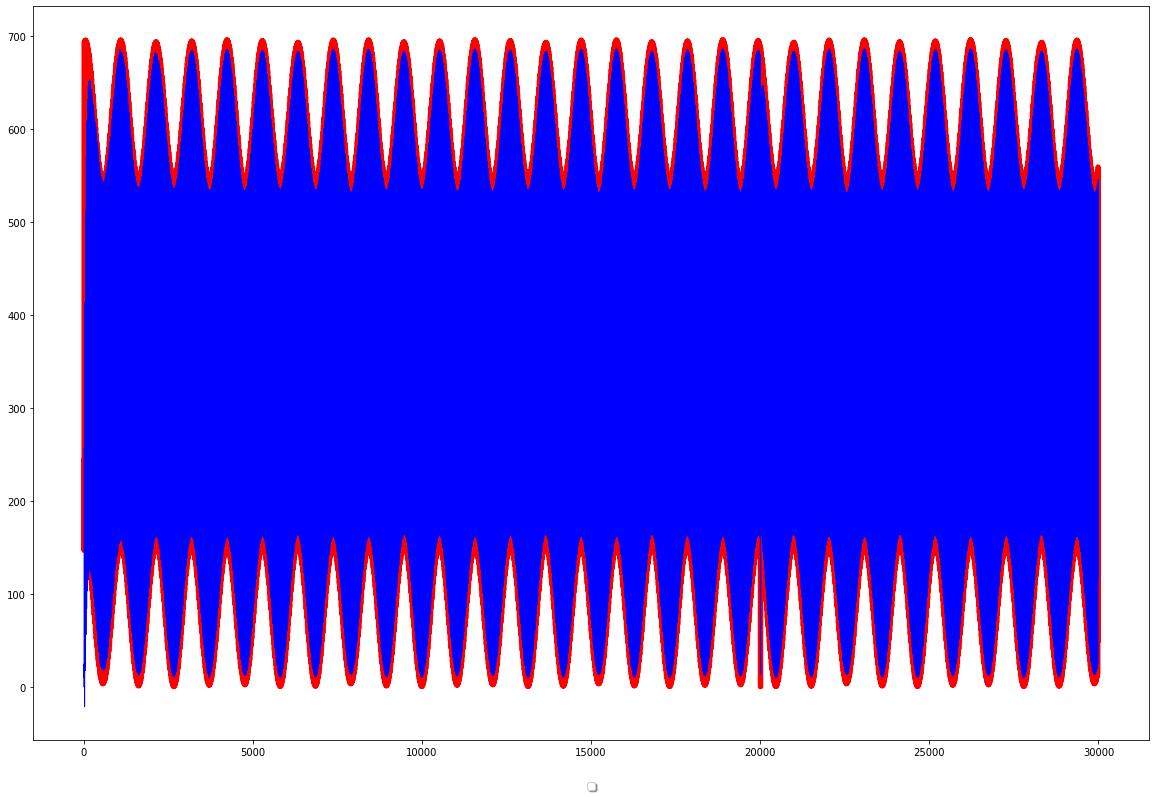

In [12]:
figure = plt.figure(figsize = (20, 15))
ax = plt.subplot(111)
line = ax.plot(np.arange(0, len(y), 1), y, 'r', linewidth=5)
line2 = ax.plot(np.arange(0, len(predicted), 1), predicted, 'b', linewidth=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=2)

plt.show()